# Advent of code 2016

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2016/advent_of_code_2016.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2016/advent_of_code_2016.ipynb)
with Python solutions to the
[2016 Advent of Code puzzles](https://adventofcode.com/2016),
completed in April 2023,
by [Hugues Hoppe](https://hhoppe.com/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 4 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)<br/>
It seems difficult to further speed up the solutions because a key bottleneck is successive calls to MD5 hashing.

Here are some visualization results:

<p>
<a href="#day1">day1</a> <img src="results/day1a.gif" width="256"> &emsp;
<a href="#day8">day8</a> <img src="results/day8a.gif" width="300">
</p>

<p>
<a href="#day11">day11</a> <img src="results/day11a.gif" width="140"> &emsp;
  <img src="results/day11b.gif" width="190">
</p>

<p>
<a href="#day13">day13</a> <img src="results/day13a.gif" width="256"> &emsp;
<a href="#day18">day18</a> <img src="results/day18.png" width="200">
</p>

<p>
<a href="#day24">day24</a> <img src="results/day24.gif" width="640">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-hhoppe advent-of-code-ocr hhoppe-tools mediapy \
  more-itertools numba numpy

In [3]:
import collections
from collections.abc import Callable, Iterable, Iterator
import dataclasses
import enum
import functools
import hashlib
import heapq
import itertools
import math
import multiprocessing
import pathlib
import re
from typing import Any

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import advent_of_code_ocr  # https://github.com/bsoyka/advent-of-code-ocr/blob/main/advent_of_code_ocr/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import mediapy as media  # https://github.com/google/mediapy/blob/main/mediapy/__init__.py
import more_itertools
import numba
import numpy as np

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [6]:
hh.start_timing_notebook_cells()

In [7]:
YEAR = 2016
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
# echo 53616... >~/.config/aocd/token  # session cookie from "adventofcode.com" (valid 1 month).

In [8]:
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
advent = advent_of_code_hhoppe.Advent(year=YEAR, tar_url=TAR_URL)

In [9]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [10]:
check_eq = hh.check_eq

In [11]:
_ORIGINAL_GLOBALS = list(globals())

In [12]:
# CPython has two implementations of MD5 hashing (https://stackoverflow.com/a/60254866):
# - https://github.com/python/cpython/blob/main/Modules/_hashopenssl.c (hashlib) and
# - https://github.com/python/cpython/blob/main/Modules/md5module.c (_md5).
# %timeit hashlib.md5(b'hello world')  # ~145 ns.
# import _md5
# %timeit _md5.md5(b'hello world')  # ~55 ns.
def _get_md5() -> Any:
  try:
    import _md5  # pytype: disable=import-error

    return _md5.md5

  except ModuleNotFoundError:
    return hashlib.md5

Note:
The MD5 algorithm encodes a message by operating on 64-byte chunks.
It pads the message to a 64-byte chunk by encoding the message length in the last 4-5 bytes.
Therefore, for small messages (< 64 bytes), there is no opportunity to reuse *any* work across
different messages with the same prefix &mdash;
the MD5 library does not actually start hashing until the `digest()` call.
The function hashlib.md5().copy() is only beneficial for some minor class initialization overhead.

Note: I get the same puzzle input for both my profiles on the following days: 04, 07, 12, 13.

<a name="day1"></a>
## Day 1: Turtle walk

- Part 1: How many blocks away is Easter Bunny HQ?

- Part 2: How many blocks away is the first location you visit twice?

In [13]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2016/day/1), `puzzle.input` has a single line of 592 characters:

R5, R4, R2, L3, R1, R1, L4, L5, R3, L1, L1, R4, L2, R1, R4, R4, L2, L2, R4, L4,  ...  R1, R1, R2, R1, R5, L1, L3, L5, R2


The stored answers are: `{1: '231', 2: '147'}`

In [14]:
def day1(s, *, part2=False):
  y, x = 0, 0  # Origin.
  dy, dx = -1, 0  # Up.
  visited = set()
  for op in s.split(', '):
    match op[0]:
      case 'L':
        dy, dx = -dx, dy
      case 'R':
        dy, dx = dx, -dy
      case _:
        raise ValueError(op)
    distance = int(op[1:])
    if not part2:
      y, x = y + dy * distance, x + dx * distance
    else:
      for _ in range(distance):
        y, x = y + dy, x + dx
        if (y, x) in visited:
          return abs(y) + abs(x)
        visited.add((y, x))
  assert not part2
  return abs(y) + abs(x)


check_eq(day1('R2, L3'), 5)
check_eq(day1('R2, R2, R2'), 2)
check_eq(day1('R5, L5, R5, R3'), 12)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2('R8, R4, R4, R8'), 4)
puzzle.verify(2, day1_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


day1a

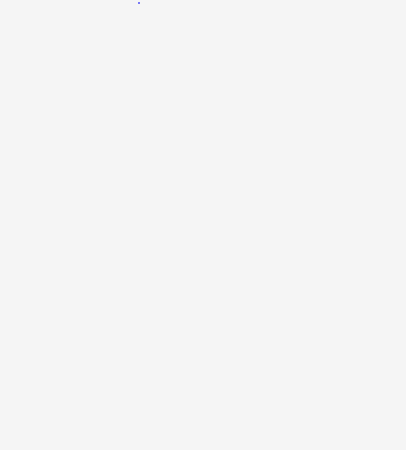

In [15]:
def day1_visualize(s, *, repeat=2):
  y, x = 0, 0  # Origin.
  dy, dx = -1, 0  # Up.
  points_list = []
  distances = []
  for op in s.split(', '):
    match op[0]:
      case 'L':
        dy, dx = -dx, dy
      case 'R':
        dy, dx = dx, -dy
    distance = int(op[1:])
    for _ in range(distance):
      y, x = y + dy, x + dx
      points_list.append([y, x])
      distances.append(distance)

  points = np.array(points_list)
  points_min = points.min(axis=0)
  shape = points.ptp(axis=0) + 3
  image = np.full((*shape, 3), 245, np.uint8)
  images = []
  visited = set()
  first_intersection = True
  time = 0.0

  for point, distance in zip(points, distances):
    yx = tuple(point - points_min + 1)
    image[yx][[0, 1]] //= 2
    if yx in visited and first_intersection:
      first_intersection = False
      y, x = yx
      image[y - 1 : y + 2, x - 1 : x + 2] = 255, 0, 0
    visited.add(yx)
    time += 1.0 if distance < 10 else 0.2
    if time >= 1.0:
      images.append(image.repeat(repeat, axis=0).repeat(repeat, axis=1))
      time -= 1.0

  y, x = yx
  image[y - 1 : y + 2, x - 1 : x + 2] = 0, 230, 0
  images.append(image.repeat(repeat, axis=0).repeat(repeat, axis=1))
  images = [images[0]] * 50 + images + [images[-1]] * 100
  media.show_video(images, codec='gif', fps=50, title='day1a')


day1_visualize(puzzle.input)

<a name="day2"></a>
## Day 2: Turtle diamond keypad

- Part 1: Your puzzle input is the instructions from the document you found at the front desk. What is the bathroom code?

- Part 2: Given diamond-shaped keypad, what is the correct bathroom code?

In [16]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2016/day/2), `puzzle.input` has 5 lines:

ULUULLUULUUUUDURUUULLDLDDRDRDULULRULLRLULRUDRRLDDLRULLLDRDRRDDLLLLDURUURDUDUUURD ... DLLUUDRDDDDRUDURDRRUUDDLRRRRURLURLD
LDLUDDLLDDRLLDLDRDDDDDUURUDDDUURLRLRLDULLLDLUDDDULLDUDLRUUDDLUULLDRLDDUDLUDDLURR ... LDUURDUUUDUURURUDRULRURLDLRDDURDLUU
DDLDRLLDRRDRRLLUUURDDULRDUDRDRUDULURLLDDLRRRUDRDLDLURRRULUDRDLULLULLDUUDRLRUDDLR ... LDUDLURRRDDULRDDRULDLUUDDLRDUURDRDR
URDURRRRUURULDLRUUDURDLLDUULULDURUDULLUDULRUDUUURLDRRULRRLLRDUURDDDLRDDRULUUURRR ... UUUDLDURURLULLLDDDULURLRRURLDDRDDLD
UDUULLRLUDLLUULRURRUUDDLLLDUURRURURDDRDLRRURLLRURLDDDRRDDUDRLLDRRUDRDRDDRURLULDD ... ULLLDDUURLDUDLLRRLRLRULLDUUUULDDUUU


The stored answers are: `{1: '52981', 2: '74CD2'}`

In [17]:
s1 = """\
ULL
RRDDD
LURDL
UUUUD
"""

In [18]:
# Part 1 keypad:
# 1 2 3
# 4 5 6
# 7 8 9
# Part 2 keypad:
#     1
#   2 3 4
# 5 6 7 8 9
#   A B C
#     D

In [19]:
def day2a_part1(s):  # Hardcoded implementation for Part 1.
  y, x = 1, 1
  code = ''
  for line in s.splitlines():
    for ch in line:
      match ch:
        case 'L':
          x = max(x - 1, 0)
        case 'R':
          x = min(x + 1, 2)
        case 'U':
          y = max(y - 1, 0)
        case 'D':
          y = min(y + 1, 2)
        case _:
          raise ValueError(ch)
    code += str(1 + y * 3 + x)
  return code


check_eq(day2a_part1(s1), '1985')
puzzle.verify(1, day2a_part1)

(Part 1: 0.000 s)


In [20]:
def day2(s, *, part2=False):  # More general constraints and lookup to also support Part 2.
  y, x = (2, 0) if part2 else (1, 1)
  code = ''
  center_y, center_x = (2, 2) if part2 else (1, 1)
  for line in s.splitlines():
    for ch in line:
      radius_y = 2 - abs(x - 2) if part2 else 1
      radius_x = 2 - abs(y - 2) if part2 else 1
      match ch:
        case 'L':
          x = max(x - 1, center_x - radius_x)
        case 'R':
          x = min(x + 1, center_x + radius_x)
        case 'U':
          y = max(y - 1, center_y - radius_y)
        case 'D':
          y = min(y + 1, center_y + radius_y)
        case _:
          raise ValueError(ch)
    code += '  1   234 56789 ABC   D  '[y * 5 + x] if part2 else str(1 + y * 3 + x)
  return code


check_eq(day2(s1), '1985')
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s1), '5DB3')
puzzle.verify(2, day2_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day3"></a>
## Day 3: Count valid triangles

- Part 1: In your puzzle input, how many of the listed triangles are possible?

- Part 2: In your puzzle input, and instead reading by columns, how many of the listed triangles are possible?

In [21]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2016/day/3), `puzzle.input` has 1_914 lines:

  775  785  361
  622  375  125
  297  839  375
  245   38  891
  503  463  849
  731  482  759
   29  734  734
  245  771  269
 ...
  130  273  957
  243   85  734
  696  302  809
  665  375  287


The stored answers are: `{1: '1032', 2: '1838'}`

In [22]:
# "In a valid triangle, the sum of any two sides must be larger than the remaining side."

In [23]:
def day3a_part1(s):
  count = 0
  for line in s.splitlines():
    values = map(int, line.split())
    count += all(a + b > c for a, b, c in itertools.permutations(values))
  return count


puzzle.verify(1, day3a_part1)

(Part 1: 0.002 s)


In [24]:
def day3(s, *, part2=False):  # Using numpy to permute lookup of values for Part 2.
  grid = np.array([line.split() for line in s.splitlines()], int)
  if part2:
    grid = grid.reshape((-1, 3, 3)).transpose(0, 2, 1).reshape((-1, 3))
  return sum(all(a + b > c for a, b, c in itertools.permutations(values)) for values in grid)


puzzle.verify(1, day3a_part1)
day3_part2 = functools.partial(day3, part2=True)
puzzle.verify(2, day3_part2)

(Part 1: 0.002 s)
(Part 2: 0.003 s)


<a name="day4"></a>
## Day 4: Decrypt names

- Part 1: What is the sum of the sector IDs of the real rooms?

- Part 2: What is the sector ID of the room where North Pole objects are stored?

In [25]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2016/day/4), `puzzle.input` has 974 lines:

aczupnetwp-mfyyj-opalcexpye-977[peyac]
qzchnzbshud-cxd-trdq-sdrshmf-105[jqexn]
molgbzqfib-bdd-mrozexpfkd-289[bdfmo]
enzcntvat-pnaql-qrfvta-351[antqv]
otzkxtgzoutgr-jek-vaxingyotm-670[tgokx]
fmsledevhsyw-gerhc-gsexmrk-qerekiqirx-126[ersgh]
yknnkoera-zua-ykjpwejiajp-212[rfzym]
dfcxsqhwzs-qobrm-gvwddwbu-532[dwbqs]
 ...
udglrdfwlyh-gbh-ghyhorsphqw-465[hgdlr]
krxqjijamxdb-kdwwh-vjatncrwp-823[kvmoi]
tpspahyf-nyhkl-kfl-aljouvsvnf-981[flahk]
bxaxipgn-vgpst-qphzti-rdcipxcbtci-635[ipctx]


The stored answers are: `{1: '361724', 2: '482'}`

In [26]:
# spellcheck=off
s1 = """\
aaaaa-bbb-z-y-x-123[abxyz]
a-b-c-d-e-f-g-h-987[abcde]
not-a-real-room-404[oarel]
totally-real-room-200[decoy]
"""

s2 = 'qzmt-zixmtkozy-ivhz'
# spellcheck=on

In [27]:
def day4(s, *, part2=False):
  def decrypt_name(name: str, n: int) -> str:
    return ''.join(
        ' ' if ch == '-' else chr(ord('a') + (ord(ch) - ord('a') + n) % 26) for ch in name
    )

  check_eq(decrypt_name(s2, 343), 'very encrypted name')

  sum_sectors = 0
  for line in s.splitlines():
    pattern = r'^([a-z-]+)-(\d+)\[([a-z]+)\]$'
    name, sector, checksum = hh.re_groups(pattern, line)
    counter = collections.Counter(sorted(ch for ch in name if ch.islower()))
    expected = ''.join(dict(counter.most_common(len(checksum))).keys())
    if expected == checksum:
      sum_sectors += int(sector)
      if part2 and decrypt_name(name, int(sector)) == 'northpole object storage':
        return sector

  assert not part2
  return sum_sectors


check_eq(day4(s1), 1514)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
puzzle.verify(2, day4_part2)

(Part 1: 0.008 s)
(Part 2: 0.005 s)


<a name="day5"></a>
## Day 5: MD5 hash search

- Part 1: Given the actual Door ID, what is the password?

- Part 2: Given the actual Door ID and this new method, what is the password?

In [28]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2016/day/5), `puzzle.input` has a single line of 8 characters:

wtnhxymk


The stored answers are: `{1: '2414bc77', 2: '437e60fc'}`

In [29]:
def day5a(s, *, part2=False):  # Serial solution; compact but slow.
  md5 = _get_md5()
  s = s.strip()
  password = ['_'] * 8 if part2 else []
  for index in itertools.count():
    hashed = md5((s + str(index)).encode()).hexdigest()
    if hashed[:5] == '00000':
      if part2:
        position = int(hashed[5], 16)
        if position < 8 and password[position] == '_':
          password[position] = hashed[6]
          if '_' not in password:
            return ''.join(password)
      else:
        password.append(hashed[5])
        if len(password) == 8:
          return ''.join(password)


# check_eq(day5a('abc'), '18f47a30')
# puzzle.verify(1, day5a)  # ~3.7 s using _md5 (~5.3 s using hashlib).

day5a_part2 = functools.partial(day5a, part2=True)
# check_eq(day5a_part2('abc'), '05ace8e3')
# puzzle.verify(2, day5a_part2)  # ~10.5 s using _md5 (~16.5 s using hashlib).

In [30]:
# Faster multiprocessing solution; also, small speedup using digest() rather than hexdigest().
def day5(s, *, part2=False):
  def find_hashes(s, start, stop):
    md5 = _get_md5()
    results = []
    prefix = s.encode()
    # hasher0 = md5(prefix)
    for index in range(start, stop):
      # hasher = hasher0.copy()
      # hasher.update(str(index).encode())
      # hasher = md5((s + str(index)).encode())
      hasher = md5(prefix + bytes(str(index), 'ascii'))
      digest = hasher.digest()
      if digest[:2] == b'\0\0' and digest.hex()[4] == '0':
        results.append(index)
    return results

  s = s.strip()
  md5 = _get_md5()
  password = ['_'] * 8 if part2 else []
  group_size = 2_000_000 if part2 else 500_000
  header = 'from typing import Any'
  with hh.function_in_temporary_module(find_hashes, header=header, funcs=[_get_md5]) as function:
    with multiprocessing.Pool() as pool:
      for base in itertools.count(0, group_size):
        chunk_size = group_size // multiprocessing.cpu_count() + 1
        args = []
        start, group_stop = base, base + group_size
        while start < group_stop:
          stop = min(start + chunk_size, group_stop)
          args.append((s, start, stop))
          start = stop
        results = pool.starmap(function, args)
        for index in more_itertools.flatten(results):
          hashed = md5((s + str(index)).encode()).hexdigest()
          check_eq(hashed[:5], '00000')
          if part2:
            position = int(hashed[5], 16)
            if position < 8 and password[position] == '_':
              password[position] = hashed[6]
              if '_' not in password:
                return ''.join(password)
          else:
            password.append(hashed[5])
            if len(password) == 8:
              return ''.join(password)


check_eq(day5('abc'), '18f47a30')
puzzle.verify(1, day5)

day5_part2 = functools.partial(day5, part2=True)
# check_eq(day5_part2('abc'), '05ace8e3')
puzzle.verify(2, day5_part2)

(Part 1: 0.458 s)
(Part 2: 1.076 s)


<a name="day6"></a>
## Day 6: Most/least common letters

- Part 1: Given the recording in your puzzle input, what is the error-corrected version of the message being sent?

- Part 2: Given the recording in your puzzle input and this new decoding methodology, what is the original message that Santa is trying to send?

In [31]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2016/day/6), `puzzle.input` has 598 lines:

jtfxgqec
zxoeuddn
anlfufma
dxuuyxkg
ttnewhlw
sjoyeiry
rgfwwdhw
qymxsllk
 ...
kpxiuodk
johmsncc
enhamlol
yhtydoss


The stored answers are: `{1: 'tsreykjj', 2: 'hnfbujie'}`

In [32]:
# spellcheck=off
s1 = """\
eedadn
drvtee
eandsr
raavrd
atevrs
tsrnev
sdttsa
rasrtv
nssdts
ntnada
svetve
tesnvt
vntsnd
vrdear
dvrsen
enarar
"""
# spellcheck=on

In [33]:
def day6(s, *, part2=False):
  lines = s.splitlines()
  counters = [collections.Counter(line[i] for line in lines) for i in range(len(lines[0]))]
  return ''.join(counter.most_common()[-1 if part2 else 0][0] for counter in counters)


check_eq(day6(s1), 'easter')
puzzle.verify(1, day6)

day6_part2 = functools.partial(day6, part2=True)
check_eq(day6_part2(s1), 'advent')
puzzle.verify(2, day6_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day7"></a>
## Day 7: Finding substrings

- Part 1: How many IPs in your puzzle input support TLS?

- Part 2: How many IPs in your puzzle input support SSL?

In [34]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2016/day/7), `puzzle.input` has 2_000 lines:

rhamaeovmbheijj[hkwbkqzlcscwjkyjulk]ajsxfuemamuqcjccbc
gdlrknrmexvaypu[crqappbbcaplkkzb]vhvkjyadjsryysvj[nbvypeadikilcwg]jwxlimrgakadpxu[dgoanojvdvwfabtt]yqsalmulblolkgsheo
dqpthtgufgzjojuvzvm[eejdhpcqyiydwod]iingwezvcbtowwzc[uzlxaqenhgsebqskn]wcucfmnla ... wcsxeitcobaylhbvc]klxammurpqgmpsxsr
gmmfbtpprishiujnpdi[wedykxqyntvrkfdzom]uidgvubnregvorgnhm
txxplravpgztjqcw[txgmmtlhmqpmmwp]bmhfgpmafxqwtrpr[inntmjmgqothdzfqgxq]cvtwvembpvdmcvk
gkxjhpayoyrrpcr[mwyoahlkqyhtznyzrm]mvmurvsrgjunjjepn[mkoumuohilpcfgbmsmh]hpwggyv ... uzbewpjzlyqmkhw]nniczueulxtdsmkniex
vuzyoofrvaanszwndyt[mzcbhmabgnetrpje]tqnygwhmwrbyosbke[gehqzyhlnyufknqmueo]ngendggbjcvazwol
vdnploylmxnipfudw[pbkxlaozhqhlbzz]kpxnzwjhybgcenyw[fpukiqrjraomftt]rosyxtsdltbsm ... wrucjfwuyypmiic]ydnbgvicfnmwzuatudd
 ...
sgjjqocmmcccpem[odeofpebaahroicm]pluzqzwkdzcovxic[zmyulzpuuiabvykn]ylxzlyooxnlibiy
btrucplpxrokmcts[gytdxlzkfakenliallw]qhxznozsjsvhvnzhf
nefefqadkmytguyp[ucqagcoyxinbrvbw]neksoxgtnnfojobtx[bxhdwvwfhybtbzkijj]poayieifs ... 

The stored answers are: `{1: '110', 2: '242'}`

In [35]:
def day7_part1(s):
  def is_valid(line: str) -> bool:
    found_valid = False
    in_bracket = False
    for i, ch in enumerate(line[:-3]):
      match ch:
        case '[':
          assert not in_bracket
          in_bracket = True
        case ']':
          assert in_bracket
          in_bracket = False
        case _:
          ch1, ch2, ch3 = line[i + 1], line[i + 2], line[i + 3]
          if ch == ch3 and ch1 == ch2 and ch != ch1 and ch1 not in '[]':
            if in_bracket:
              return False
            found_valid = True
    return found_valid

  check_eq(is_valid('abba[mnop]qrst'), True)
  check_eq(is_valid('abcd[bddb]xyyx'), False)
  check_eq(is_valid('aaaa[qwer]tyui'), False)
  check_eq(is_valid('ioxxoj[asdfgh]zxcvbn'), True)

  return sum(is_valid(line) for line in s.splitlines())


puzzle.verify(1, day7_part1)

(Part 1: 0.018 s)


In [36]:
def day7_part2(s):
  def is_valid(line: str) -> bool:
    found_inside = set()  # Contains 'aba' iff 'bab' is inside any brackets.
    in_bracket = False
    for i, ch in enumerate(line[:-2]):
      match ch:
        case '[':
          in_bracket = True
        case ']':
          in_bracket = False
        case _:
          if in_bracket:
            s3 = line[i : i + 3]
            if ch == s3[2] and ch != s3[1] and s3[1] not in '[]':
              found_inside.add(s3[1] + s3[0] + s3[1])

    in_bracket = False
    for i, ch in enumerate(line[:-2]):
      match ch:
        case '[':
          in_bracket = True
        case ']':
          in_bracket = False
        case _:
          if not in_bracket and ch == line[i + 2] and line[i : i + 3] in found_inside:
            return True

    return False

  check_eq(is_valid('aba[bab]xyz'), True)
  check_eq(is_valid('xyx[xyx]xyx'), False)
  check_eq(is_valid('aaa[kek]eke'), True)
  check_eq(is_valid('zazbz[bzb]cdb'), True)

  return sum(is_valid(line) for line in s.splitlines())


puzzle.verify(2, day7_part2)

(Part 2: 0.021 s)


<a name="day8"></a>
## Day 8: Row and column rolls

- Part 1: How many pixels should be lit?

- Part 2: What code is the screen trying to display?

In [37]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2016/day/8), `puzzle.input` has 153 lines:

rect 1x1
rotate row y=0 by 2
rect 1x1
rotate row y=0 by 5
rect 1x1
rotate row y=0 by 3
rect 1x1
rotate row y=0 by 3
 ...
rotate column x=3 by 5
rotate column x=2 by 5
rotate column x=1 by 3
rotate column x=0 by 4


The stored answers are: `{1: '110', 2: 'ZJHRKCPLYJ'}`

In [38]:
s1 = """\
rect 3x2
rotate column x=1 by 1
rotate row y=0 by 4
rotate column x=1 by 1
"""

In [39]:
def day8(s, *, part2=False, shape=(6, 50), visualize=False, repeat=8):
  grid = np.full(shape, '.')
  images = []
  for line in s.splitlines():
    if 'rect' in line:
      width, height = map(int, line.split()[1].split('x'))
      grid[:height, :width] = '#'
    else:
      s1, s2 = line.split('=')
      index, rotation = map(int, s2.split(' by '))
      if 'row' in s1:
        grid[index] = np.roll(grid[index], rotation)
      else:  # 'column' in s1.
        grid[:, index] = np.roll(grid[:, index], rotation)

    if visualize:
      image = hh.to_image(grid == '#', 255, 0)
      image = hh.pad_array(image, 1, (230,) * 3)
      images.append(image.repeat(repeat, axis=0).repeat(repeat, axis=1))

  text = '\n'.join(''.join(ch for ch in line) for line in grid)

  if visualize:
    hh.display_html(text.replace('.', '⬜').replace('#', '⬛').replace('\n', '<br/>'))
    images = [images[0]] * 15 + images + [images[-1]] * 40
    media.show_video(images, codec='gif', fps=20, title='day8a')

  if part2:
    return advent_of_code_ocr.convert_6(text)

  return np.count_nonzero(grid == '#')


check_eq(day8(s1, shape=(3, 7)), 6)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
puzzle.verify(2, day8_part2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


day8a

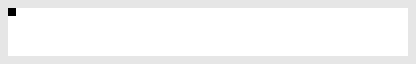

In [40]:
_ = day8(puzzle.input, visualize=True)

<a name="day9"></a>
## Day 9: Recursive string expansion

- Part 1: What is the decompressed length of the file (your puzzle input)? Don't count whitespace.

- Part 2: What is the decompressed length of the file using this improved format?

In [41]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2016/day/9), `puzzle.input` has a single line of 11_902 characters:

LGOFNEIZBERESE(15x10)WREHFFHTWBHRRRU(53x15)(8x13)ZSLUBGUV(2x10)BP(6x8)SQVMPH(7x1 ... )PIVCAXCKZMIUXAEIPFVQF(8x1)EKZBFTRW


The stored answers are: `{1: '102239', 2: '10780403063'}`

In [42]:
def day9(s, *, part2=False):
  s = s.strip()
  size = 0
  index = 0
  while index < len(s):
    if s[index].isupper():
      size += 1
      index += 1
    else:
      check_eq(s[index], '(')
      index2 = s.index(')', index)
      nchar, ntimes = map(int, s[index + 1 : index2].split('x'))
      length = day9(s[index2 + 1 : index2 + 1 + nchar], part2=part2) if part2 else nchar
      size += length * ntimes
      index = index2 + 1 + nchar

  check_eq(index, len(s))
  return size


check_eq(day9('ADVENT'), 6)
check_eq(day9('A(1x5)BC'), 7)
check_eq(day9('(3x3)XYZ'), 9)
check_eq(day9('A(2x2)BCD(2x2)EFG'), 11)
check_eq(day9('(6x1)(1x3)A'), 6)
check_eq(day9('X(8x2)(3x3)ABCY'), 18)
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2('ADVENT'), 6)
check_eq(day9_part2('A(1x5)BC'), 7)
check_eq(day9_part2('(3x3)XYZ'), 9)
check_eq(day9_part2('A(2x2)BCD(2x2)EFG'), 11)
check_eq(day9_part2('X(8x2)(3x3)ABCY'), 20)
check_eq(day9_part2('(27x12)(20x12)(13x14)(7x10)(1x12)A'), 241_920)
check_eq(day9_part2('(25x3)(3x3)ABC(2x3)XY(5x2)PQRSTX(18x9)(3x2)TWO(5x7)SEVEN'), 445)
puzzle.verify(2, day9_part2)  # E.g., 10_780_403_063

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day10"></a>
## Day 10: Bots distributing numbers

- Part 1: What is the number of the bot that is responsible for comparing value-61 microchips with value-17 microchips?

- Part 2: What do you get if you multiply together the values of one chip in each of outputs 0, 1, and 2?

In [43]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2016/day/10), `puzzle.input` has 231 lines:

bot 59 gives low to bot 176 and high to bot 120
bot 92 gives low to bot 42 and high to bot 187
value 31 goes to bot 114
bot 182 gives low to bot 49 and high to bot 176
bot 17 gives low to bot 181 and high to bot 162
bot 36 gives low to bot 118 and high to bot 121
bot 118 gives low to bot 164 and high to bot 55
bot 172 gives low to bot 79 and high to bot 123
 ...
value 5 goes to bot 92
bot 35 gives low to output 3 and high to bot 50
bot 152 gives low to output 8 and high to bot 190
bot 143 gives low to bot 163 and high to bot 33


The stored answers are: `{1: '47', 2: '2666'}`

In [44]:
if 1:
  hh.display_html(str(re.findall(r'(?m)^value 17.*$', puzzle.input)))
  hh.display_html(str(re.findall(r'(?m)^value 61.*$', puzzle.input)))

In [45]:
s1 = """\
value 5 goes to bot 2
bot 2 gives low to bot 1 and high to bot 0
value 3 goes to bot 1
bot 1 gives low to output 1 and high to bot 0
bot 0 gives low to output 2 and high to output 0
value 2 goes to bot 2
"""

In [46]:
def day10(s, *, part2=False, values=(17, 61)):
  low_high_for_bot: dict[str, tuple[str, str]] = {}
  values_for_node = collections.defaultdict[str, set[int]](set)
  queue = collections.deque[tuple[str, int]]()
  for line in s.splitlines():
    if 'goes to' in line:
      s_value, bot = line[6:].split(' goes to ')
      value = int(s_value)
      queue.append((bot, value))
    else:
      pattern = r'^(bot \d+) gives low to (.+) and high to (.+)$'
      src, dst_low, dst_high = hh.re_groups(pattern, line)
      low_high_for_bot[src] = dst_low, dst_high

  while queue:
    bot, value = queue.popleft()
    set_ = values_for_node[bot]
    assert value not in set_ and len(set_) <= 1
    set_.add(value)
    if len(set_) == 2:
      dst_low, dst_high = low_high_for_bot[bot]
      queue.append((dst_low, min(set_)))
      queue.append((dst_high, max(set_)))

  if not part2:
    (bot,) = (bot for bot, value in values_for_node.items() if value == set(values))
    return bot[4:]

  return math.prod(values_for_node[f'output {i}'].pop() for i in range(3))


check_eq(day10(s1, values=(2, 5)), '2')
puzzle.verify(1, day10)

day10_part2 = functools.partial(day10, part2=True)
puzzle.verify(2, day10_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day11"></a>
## Day 11: Elevator to move parts

- Part 1: "if a chip is ever left in the same area as another RTG, and it's not connected to its own RTG, the chip will be fried"; "the elevator will only function if it contains at least one RTG or microchip"; what is the minimum number of steps required to bring all of the objects to the fourth floor?

- Part 2: What is the minimum number of steps required to bring all of the objects, including these four new ones, to the fourth floor?

In [47]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2016/day/11), `puzzle.input` has 4 lines:

The first floor contains a strontium generator, a strontium-compatible microchip ... d a plutonium-compatible microchip.
The second floor contains a thulium generator, a ruthenium generator, a rutheniu ...  and a curium-compatible microchip.
The third floor contains a thulium-compatible microchip.
The fourth floor contains nothing relevant.


The stored answers are: `{1: '37', 2: '61'}`

In [48]:
s1 = """\
The first floor contains a hydrogen-compatible microchip and a lithium-compatible microchip.
The second floor contains a hydrogen generator.
The third floor contains a lithium generator.
The fourth floor contains nothing relevant.
"""

In [49]:
def day11a(s, *, part2=False):  # Simplest but slow; BFS with queue; set[str]; unpruned.
  initial_contents: list[set[str]] = [set() for _ in range(4)]
  for floor, line in enumerate(s.splitlines()):
    if 'nothing relevant' not in line:
      for name in re.split(r',? and |, ', line[:-1].split(' contains ')[1]):
        name2 = re.split(r' |-', name)[1]
        initial_contents[floor].add(name2.upper() if 'generator' in name else name2)
  initial_contents[0] |= set('elerium ELERIUM dilithium DILITHIUM'.split() if part2 else [])
  start_state = 0, initial_contents
  end_state = 3, [set(), set(), set(), set.union(*initial_contents)]

  def encode(floor: int, contents: list[set[str]]) -> Any:
    return floor, *(frozenset(set_) for set_ in contents)

  def disallowed(items: set[str]) -> bool:
    return any(item.isupper() for item in items) and any(
        item.islower() and item.upper() not in items for item in items
    )

  seen = set([encode(*start_state)])
  queue = collections.deque([(start_state[0], start_state[1], 0)])  # Expand to help pytype.

  while queue:
    floor, contents, distance = queue.popleft()
    for floor2 in (floor + offset for offset in [-1, 1] if 0 <= floor + offset < 4):
      for items in more_itertools.flatten(
          itertools.combinations(contents[floor], n) for n in [1, 2]
      ):
        leftover = contents[floor] - set(items)
        newgroup = contents[floor2] | set(items)
        if disallowed(set(items)) or disallowed(leftover) or disallowed(newgroup):
          continue
        contents2 = contents.copy()
        contents2[floor] = leftover
        contents2[floor2] = newgroup
        state2 = floor2, contents2
        encoded2 = encode(*state2)
        if encoded2 not in seen:
          if state2 == end_state:
            return distance + 1
          seen.add(encoded2)
          queue.append((*state2, distance + 1))


check_eq(day11a(s1), 11)
# puzzle.verify(1, day11a)  # ~5.6 s.

day11a_part2 = functools.partial(day11a, part2=True)
# (Note that Part 2 applied to sample `s1` has no solution.)
# puzzle.verify(2, day11a_part2)  # ~315 s.!

In [50]:
def day11b(s, *, part2=False, visualize=False):  # BFS; frozenset[int]; equivalency; pruned search.
  names = sorted(re.findall(r'(\w+) generator', s))
  initial_contents: list[list[int]] = [[] for _ in range(4)]
  for floor, line in enumerate(s.splitlines()):
    generator_names = re.findall(r'(\w+) generator', line)
    initial_contents[floor].extend(1 + names.index(name) for name in generator_names)
    chip_names = re.findall(r'(\w+)-compatible', line)
    initial_contents[floor].extend(-1 - names.index(name) for name in chip_names)
  if part2:
    initial_contents[0].extend([1 + len(names), -1 - len(names)])
    initial_contents[0].extend([2 + len(names), -2 - len(names)])
  all_content = frozenset(more_itertools.flatten(initial_contents))
  start_state = 0, tuple(frozenset(set_) for set_ in initial_contents)
  end_state: Any = 3, (frozenset(), frozenset(), frozenset(), all_content)

  def show_visualization() -> None:
    images = []
    state = end_state
    while state:
      _, contents = state
      image = np.full((4, len(all_content) * 3 // 2 - 1, 3), 245, 'uint8')
      for floor, content in enumerate(contents):
        for index in content:
          color = (150, 150, 255) if index < 0 else (80, 80, 255)
          image[floor, (abs(index) - 1) * 3 + (index < 0)] = color
      images.append(image[::-1].repeat(12, axis=0).repeat(12, axis=1))
      state = prev[state]
    images = images[::-1]
    images = [images[0]] * 5 + images + [images[-1]] * 5
    title = f'day11{"b" if part2 else "a"}' if len(all_content) > 4 else None
    media.show_video(images, codec='gif', border=True, fps=3, title=title)

  @functools.cache  # 1K entries for part1; 7K for part2.
  def disallowed(items: frozenset[int]) -> bool:
    return any(item > 0 for item in items) and any(-item not in items for item in items if item < 0)

  @functools.cache  # 200 entries for part1; 600 for part2.
  def candidate_items(content: frozenset[int]) -> tuple[tuple[int, ...], ...]:
    return tuple(more_itertools.flatten(itertools.combinations(content, n) for n in [1, 2]))

  def estimated_goodness(state: Any) -> int:
    unused_floor, contents = state
    return -(len(contents[0]) * 3 + len(contents[1]) * 2 + len(contents[2]) * 1)

  @functools.cache  # 300 entries for part1; 1800 for part2.
  def encode1(content: frozenset[int]) -> tuple[int, int]:
    return sum(1 for index in content if index > 0), sum(1 for index in content if index < 0)

  def encode(state: Any) -> Any:
    """Account for the fact that only the counts of gens and chips on each floor matters."""
    floor, c = state
    return floor, encode1(c[0]), encode1(c[1]), encode1(c[2]), encode1(c[3])

  prune_size = 50  # Heuristic; may fail if too small!
  seen: Any = {encode(start_state)}
  prev: Any = {start_state: None}
  states = [start_state]
  distance = 0

  while states:
    states2 = []

    for state in states:
      if state == end_state:
        if visualize:
          show_visualization()
        # hh.analyze_functools_caches(locals())
        return distance
      floor, contents = state
      for floor2 in (floor + offset for offset in [1, -1] if 0 <= floor + offset < 4):
        for items in candidate_items(contents[floor]):
          leftover = contents[floor].difference(items)
          if disallowed(leftover):
            continue
          newgroup = contents[floor2].union(items)
          if disallowed(newgroup):
            continue
          contents2 = list(contents)
          contents2[floor] = leftover
          contents2[floor2] = newgroup
          state2 = floor2, tuple(contents2)
          encoded_state2 = encode(state2)
          if encoded_state2 not in seen:
            seen.add(encoded_state2)
            prev[state2] = state
            states2.append(state2)

    states = states2
    if len(states) > prune_size:
      states = sorted(states, key=estimated_goodness)[-prune_size:]
    distance += 1
    # hh.show(distance, len(states))  # Bell-shaped, max at 13_000 in Part1, 240_000 in Part 2.


check_eq(day11b(s1), 11)
puzzle.verify(1, day11b)

day11b_part2 = functools.partial(day11b, part2=True)
puzzle.verify(2, day11b_part2)

(Part 1: 0.021 s)
(Part 2: 0.062 s)


""

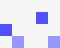

day11a

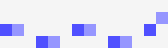

day11b

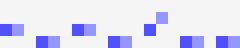

In [51]:
_ = day11b(s1, visualize=True)
_ = day11b(puzzle.input, part2=False, visualize=True)
_ = day11b(puzzle.input, part2=True, visualize=True)

In [52]:
# hh.prun(lambda: day11b(puzzle.input, part2=True), top=10)

In [53]:
# use Dijkstra/A* instead of pruned BFS?

In [54]:
def day11c(s, *, part2=False):  # BFS; list of floors; equivalency; unpruned.
  # Inspired from https://github.com/narimiran/advent_of_code_2016/blob/master/python/day_11.py
  # The approach is to assume that two *valid* states are interchangeable if they have the same
  # number of generators and chips on corresponding floors.
  names = sorted(re.findall(r'(\w+) generator', s))
  lines = s.splitlines()
  gens = [next(f for f, l in enumerate(lines) if f'{name} generator' in l) for name in names]
  chips = [next(f for f, l in enumerate(lines) if f'{name}-compatible' in l) for name in names]
  if part2:
    gens, chips = [0, 0] + gens, [0, 0] + chips
  num = len(gens)
  positions = gens + chips
  seen = set()

  def consider(positions: list[int], floor: int, queue: Any) -> None:
    gens, chips = positions[:num], positions[num:]
    if any(chip != gen and chip in gens for gen, chip in zip(gens, chips)):
      return
    hash_ = tuple((gens.count(i), chips.count(i)) for i in range(4)) + (floor,)
    if hash_ not in seen:
      seen.add(hash_)
      queue.append((positions.copy(), floor))

  queue: list[tuple[list[int], int]] = []
  consider(positions, 0, queue)
  steps = 0

  while queue:
    queue2: list[tuple[list[int], int]] = []

    for positions, floor in queue:
      if all(position == 3 for position in positions):
        return steps

      for index1, position1 in enumerate(positions):
        if position1 == floor:
          for floor2 in [floor + 1, floor - 1]:
            if 0 <= floor2 < 4:
              positions[index1] = floor2
              consider(positions, floor2, queue2)
              for index2, position2 in enumerate(positions[index1 + 1 :], index1 + 1):
                if position2 == floor:
                  positions[index2] = floor2
                  consider(positions, floor2, queue2)
                  positions[index2] = floor
              positions[index1] = floor

    queue = queue2
    steps += 1

  raise ValueError('No solution exists.')


check_eq(day11c(s1), 11)
puzzle.verify(1, day11c)

day11c_part2 = functools.partial(day11c, part2=True)
puzzle.verify(2, day11c_part2)

(Part 1: 0.053 s)
(Part 2: 0.295 s)


In [55]:
# Same but faster using numba -- we must omit the convenient list and generator comprehensions.
@numba.njit
def day11_compute(positions0: np.ndarray) -> int:
  # Inspired from https://github.com/narimiran/advent_of_code_2016/blob/master/python/day_11.py
  positions = list(positions0)
  num = len(positions) // 2
  seen = set()

  def is_solved(positions: list[int]) -> bool:
    for position in positions:
      if position != 3:
        return False
    return True

  def consider(positions: list[int], floor: int, queue: Any) -> None:
    gens, chips = positions[:num], positions[num:]
    for index in range(num):
      gen, chip = positions[index], positions[index + num]
      if chip != gen:
        for index2 in range(num):
          if chip == positions[index2]:
            return
    hash_ = (
        (gens.count(0), gens.count(1), gens.count(2), gens.count(3))
        + (chips.count(0), chips.count(1), chips.count(2), chips.count(3))
        + (floor,)
    )
    if hash_ not in seen:
      seen.add(hash_)
      queue.append((positions.copy(), floor))

  queue: list[tuple[list[int], int]] = []
  consider(positions, 0, queue)
  steps = 0

  while queue:
    queue2: list[tuple[list[int], int]] = []

    for positions, floor in queue:
      if is_solved(positions):
        return steps

      for index1, position1 in enumerate(positions):
        if position1 == floor:
          for floor2 in [floor + 1, floor - 1]:
            if 0 <= floor2 < 4:
              positions[index1] = floor2
              consider(positions, floor2, queue2)
              for index2, position2 in enumerate(positions[index1 + 1 :], index1 + 1):
                if position2 == floor:
                  positions[index2] = floor2
                  consider(positions, floor2, queue2)
                  positions[index2] = floor
              positions[index1] = floor

    queue = queue2
    steps += 1

  raise ValueError('No solution exists.')


def day11(s, *, part2=False):
  names = sorted(re.findall(r'(\w+) generator', s))
  lines = s.splitlines()
  gens = [next(f for f, l in enumerate(lines) if f'{name} generator' in l) for name in names]
  chips = [next(f for f, l in enumerate(lines) if f'{name}-compatible' in l) for name in names]
  if part2:
    gens, chips = [0, 0] + gens, [0, 0] + chips
  positions = gens + chips
  return day11_compute(np.array(positions))


check_eq(day11(s1), 11)
_ = day11(s1)  # For numba compilation on particular tuple length.
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
_ = day11(puzzle.input)  # For numba compilation on particular tuple length.
puzzle.verify(2, day11_part2)

(Part 1: 0.007 s)
(Part 2: 0.038 s)


<a name="day12"></a>
## Day 12: Interpret program

- Part 1: After executing the assembunny code in your puzzle input, what value is left in register a?

- Part 2: If you instead initialize register c to be 1, what value is now left in register a?

In [56]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2016/day/12), `puzzle.input` has 23 lines:

cpy 1 a
cpy 1 b
cpy 26 d
jnz c 2
jnz 1 5
cpy 7 c
inc d
dec c
 ...
dec d
jnz d -2
dec c
jnz c -5


The stored answers are: `{1: '318020', 2: '9227674'}`

In [57]:
s1 = """\
cpy 41 a
inc a
inc a
dec a
jnz a 2
dec a
"""

In [58]:
def day12a(s, *, part2=False):
  instructions = [line.split() for line in s.splitlines()]
  registers = collections.defaultdict(int)
  if part2:
    registers['c'] = 1
  program_counter = 0

  def get_value(src: str) -> int:
    return registers[src] if src.isalpha() else int(src)

  while 0 <= program_counter < len(instructions):
    match instructions[program_counter]:
      case 'cpy', src, dst:
        registers[dst] = get_value(src)
      case 'inc', register:
        registers[register] += 1
      case 'dec', register:
        registers[register] -= 1
      case 'jnz', predicate, offset:
        if get_value(predicate) != 0:
          program_counter += int(offset) - 1
      case x:
        raise ValueError(x)
    program_counter += 1

  assert set(registers) <= set('abcd')
  return registers['a']


check_eq(day12a(s1), 42)
puzzle.verify(1, day12a)

day12a_part2 = functools.partial(day12a, part2=True)
# puzzle.verify(2, day12a_part2)  # ~5.5 s.

(Part 1: 0.180 s)


In [59]:
def day12b(s, *, part2=False):  # Disappointingly not much faster.
  registers = [0] * 4
  if part2:
    registers[2] = 1
  program_counter = 0

  def get(register):
    return 'abcd'.index(register)

  def cpy_reg(src, dst):
    registers[dst] = registers[src]

  def cpy_val(value, dst):
    registers[dst] = value

  def increment(register):
    registers[register] += 1

  def decrement(register):
    registers[register] -= 1

  def jnz_reg(register, offset):
    nonlocal program_counter
    if registers[register] != 0:
      program_counter += offset - 1

  def jump(offset):
    nonlocal program_counter
    program_counter += offset - 1

  instructions: list[Callable[[], None]] = []
  for line in s.splitlines():
    match line.split():
      case 'cpy', src, dst:
        if src.isalpha():
          instructions.append(functools.partial(cpy_reg, src=get(src), dst=get(dst)))
        else:
          instructions.append(functools.partial(cpy_val, value=int(src), dst=get(dst)))
      case 'inc', register:
        instructions.append(functools.partial(increment, register=get(register)))
      case 'dec', register:
        instructions.append(functools.partial(decrement, register=get(register)))
      case 'jnz', predicate, offset:
        if predicate.isalpha():
          instructions.append(
              functools.partial(jnz_reg, register=get(predicate), offset=int(offset))
          )
        elif int(predicate) != 0:
          instructions.append(functools.partial(jump, offset=int(offset)))
        else:
          instructions.append(lambda: None)
      case _:
        raise ValueError(line)

  while 0 <= program_counter < len(instructions):
    instructions[program_counter]()
    program_counter += 1

  return registers[0]


check_eq(day12b(s1), 42)
puzzle.verify(1, day12b)

day12b_part2 = functools.partial(day12b, part2=True)
# puzzle.verify(2, day12b_part2)  # ~4.6 s.

(Part 1: 0.190 s)


In [60]:
def day12(s, *, part2=False):  # Program reimplemented in Python.
  lines = s.splitlines()
  param0 = int(hh.re_groups(r'cpy (\d+) d', lines[2])[0])  # e.g., 26
  param1 = int(hh.re_groups(r'cpy (\d+) c', lines[5])[0])  # e.g., 7
  param2 = int(hh.re_groups(r'cpy (\d+) c', lines[16])[0])  # e.g., 19
  param3 = int(hh.re_groups(r'cpy (\d+) d', lines[17])[0])  # e.g., 11
  a = 1
  b = 1
  d = param0
  if part2:
    d += param1

  for _ in range(d):
    c = a
    a += b
    b = c

  a += param2 * param3
  return a


puzzle.verify(1, day12)

day12_part2 = functools.partial(day12, part2=True)
puzzle.verify(2, day12_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [61]:
# L00 cpy 1 a
# L01 cpy 1 b
# L02 cpy 26 d
# L03 jnz c 2
# L04 jnz 1 5
# L05 cpy 7 c
# L06 inc d
# L07 dec c
# L08 jnz c -2
# L09 cpy a c
# L10 inc a
# L11 dec b
# L12 jnz b -2
# L13 cpy c b
# L14 dec d
# L15 jnz d -6
# L16 cpy 19 c
# L17 cpy 11 d
# L18 inc a
# L19 dec d
# L20 jnz d -2
# L21 dec c
# L22 jnz c -5

In [62]:
# L00 cpy 1 a    # a = 1
# L01 cpy 1 b    # b = 1
# L02 cpy 26 d   # d = 26

# L03 jnz c 2    # if c != 0:  # (Part 2)
# L04 jnz 1 5    #

# L05 cpy 7 c    #   c = 7

#                #   do
# L06 inc d      #     d += 1
# L07 dec c      #     c -= 1
# L08 jnz c -2   #   while c != 0

#                # do
# L09 cpy a c    #   c = a

#                #   do
# L10 inc a      #     a += 1
# L11 dec b      #     b -= 1
# L12 jnz b -2   #   while b != 0

# L13 cpy c b    #   b = c
# L14 dec d      #   d -= 1
# L15 jnz d -6   # while d != 0

# L16 cpy 19 c   # c = 19

#                # do
# L17 cpy 11 d   #   d = 11

#                #   do
# L18 inc a      #     a += 1
# L19 dec d      #     d -= 1
# L20 jnz d -2   #   while d != 0

# L21 dec c      #   c -= 1
# L22 jnz c -5   # while c != 0

#                # return a

<a name="day13"></a>
## Day 13: Path in procedural maze

- Part 1: What is the fewest number of steps required for you to reach 31,39 (from 1,1) ?

- Part 2: How many locations (distinct x,y coordinates, including your starting location) can you reach in at most 50 steps?

In [63]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2016/day/13), `puzzle.input` has a single line of 4 characters:

1364


The stored answers are: `{1: '86', 2: '127'}`

In [64]:
def day13a(s, *, part2=False, src_yx=(1, 1), dst_yx=(39, 31)):  # Compact without visualization.
  seed = int(s)
  sentinel = -1, -1

  def is_wall(y: int, x: int) -> bool:
    value = x * x + 3 * x + 2 * x * y + y + y * y + seed
    return bin(value).count('1') % 2 != 0

  previous = {src_yx: sentinel}
  queue = collections.deque([(src_yx, 0)])

  while queue:
    (y, x), distance = queue.popleft()
    if (not part2 and (y, x) == dst_yx) or (part2 and distance == 50):
      break
    for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
      yx2 = y2, x2 = y + dy, x + dx
      if y2 >= 0 and x2 >= 0 and yx2 not in previous and not is_wall(y2, x2):
        previous[yx2] = (y, x)
        queue.append((yx2, distance + 1))

  return len(previous) if part2 else distance


check_eq(day13a('10', dst_yx=(4, 7)), 11)
puzzle.verify(1, day13a)

day13a_part2 = functools.partial(day13a, part2=True)
puzzle.verify(2, day13a_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [65]:
def day13(s, *, part2=False, src_yx=(1, 1), dst_yx=(39, 31), visualize=False):  # Create video.
  seed = int(s)
  sentinel = -1, -1

  def is_wall(y: int, x: int) -> bool:
    value = x * x + 3 * x + 2 * x * y + y + y * y + seed
    return bin(value).count('1') % 2 != 0

  if visualize:

    def add_image(image: np.ndarray) -> None:
      image = np.pad(image, ((1, 0), (1, 0), (0, 0))).repeat(5, axis=0).repeat(5, axis=1)
      images.append(image)

    images: list[np.ndarray] = []
    shape = 50, 60
    grid_wall = np.array([is_wall(y, x) for y, x in np.ndindex(shape)]).reshape(shape)
    image = hh.to_image(grid_wall, 250, 0)
    image[src_yx] = 0, 255, 0
    image[dst_yx] = 255, 0, 0
    add_image(image)

  previous = {src_yx: sentinel}
  queue = [src_yx]
  distance = 0

  while queue and not (part2 and distance == 50):
    queue2 = []
    found = False

    for y, x in queue:
      if not part2 and (y, x) == dst_yx:
        found = True
        break
      for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        yx2 = y2, x2 = y + dy, x + dx
        if y2 >= 0 and x2 >= 0 and yx2 not in previous and not is_wall(y2, x2):
          previous[yx2] = (y, x)
          queue2.append(yx2)
      if visualize and distance > 0:
        image[y, x] = 150, 150, 255

    if found:
      break
    queue = queue2
    distance += 1
    if visualize:
      add_image(image)

  if visualize:
    if not part2:
      yx = previous[dst_yx]
      while yx != sentinel:
        image[yx] = 255, 150, 30
        yx = previous[yx]
    add_image(image)
    images = [images[0]] * 20 + images + [images[-1]] * 40
    media.show_video(images, codec='gif', fps=15, title=f'day13{"b" if part2 else "a"}')

  return len(previous) if part2 else distance


check_eq(day13('10', dst_yx=(4, 7)), 11)
puzzle.verify(1, day13)

day13_part2 = functools.partial(day13, part2=True)
puzzle.verify(2, day13_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


day13a

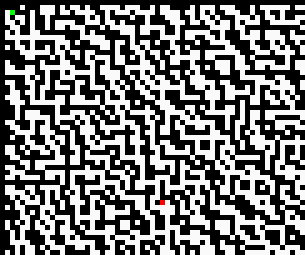

day13b

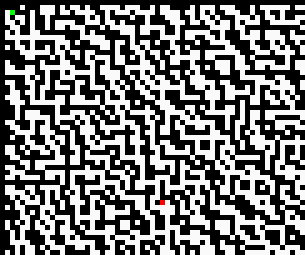

In [66]:
_ = day13(puzzle.input, visualize=True, part2=False)
_ = day13(puzzle.input, visualize=True, part2=True)

<a name="day14"></a>
## Day 14: MD5 with repeated chars

- Part 1: Given the actual salt in your puzzle input, what index produces your 64th one-time pad key?

- Part 2: Given the actual salt in your puzzle input and using 2016 extra MD5 calls of key stretching, what index now produces your 64th one-time pad key?

In [67]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2016/day/14), `puzzle.input` has a single line of 8 characters:

yjdafjpo


The stored answers are: `{1: '25427', 2: '22045'}`

In [68]:
def day14_find_triplet(hashed: str) -> str:
  for index, ch in enumerate(hashed[:-2]):
    if ch == hashed[index + 1] == hashed[index + 2]:
      return ch
  return ''

In [69]:
def day14a(s, *, part2=False):
  s = s.strip()
  md5 = _get_md5()

  def get_hashed(index: int) -> str:
    hashed = md5((s + str(index)).encode()).hexdigest()
    if part2:
      for _ in range(2016):
        hashed = md5(hashed.encode()).hexdigest()
    return hashed

  hashes = [get_hashed(index) for index in range(1000)]

  num_found = 0
  for index in itertools.count():
    hashes.append(get_hashed(len(hashes)))
    ch = day14_find_triplet(hashes[index])
    if ch and any(ch * 5 in hashed for hashed in hashes[index + 1 : index + 1001]):
      num_found += 1
      if num_found == 64:
        return index


check_eq(day14a('abc'), 22728)
puzzle.verify(1, day14a)

day14a_part2 = functools.partial(day14a, part2=True)
# check_eq(day14a_part2('abc'), 22551)  # ~10 s.
# puzzle.verify(2, day14a_part2)  # ~10 s.

(Part 1: 0.192 s)


In [70]:
# Faster multiprocessing solution.
def day14_part2(s):
  def get_hashed(s: str) -> str:
    md5 = _get_md5()
    hashed = md5(s.encode()).hexdigest()
    for _ in range(2016):
      hashed = md5(hashed.encode()).hexdigest()
    return hashed

  s = s.strip()
  header = 'from typing import Any'
  with hh.function_in_temporary_module(get_hashed, header=header, funcs=[_get_md5]) as function:
    with multiprocessing.Pool() as pool:
      hashes: list[str] = []

      def replenish_hashes(group_size=2400, chunksize=100):
        strings = [s + str(index) for index in range(len(hashes), len(hashes) + group_size)]
        new_hashes = pool.map(function, strings, chunksize)
        hashes.extend(new_hashes)

      num_found = 0
      for index in itertools.count():
        if len(hashes) < index + 1001:
          replenish_hashes()
        ch = day14_find_triplet(hashes[index])
        if ch and any(ch * 5 in hashed for hashed in hashes[index + 1 : index + 1001]):
          num_found += 1
          if num_found == 64:
            return index


# check_eq(day14_part2('abc'), 22551)  # ~1.2 s.
puzzle.verify(2, day14_part2)  # ~1.2 s using _md5 (~2.0 s using hashlib).

(Part 2: 1.139 s)


<a name="day15"></a>
## Day 15: Spinning disks

- Part 1: What is the first time you can press the button to get a capsule?

- Part 2: A new disc with 11 positions and starting at position 0 has appeared exactly one second below the previously-bottom disc.

In [71]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2016/day/15), `puzzle.input` has 6 lines:

Disc #1 has 17 positions; at time=0, it is at position 1.
Disc #2 has 7 positions; at time=0, it is at position 0.
Disc #3 has 19 positions; at time=0, it is at position 2.
Disc #4 has 5 positions; at time=0, it is at position 0.
Disc #5 has 3 positions; at time=0, it is at position 0.
Disc #6 has 13 positions; at time=0, it is at position 5.


The stored answers are: `{1: '317371', 2: '2080951'}`

In [72]:
s1 = """\
Disc #1 has 5 positions; at time=0, it is at position 4.
Disc #2 has 2 positions; at time=0, it is at position 1.
"""

In [73]:
def day15a(s, *, part2=False):  # Using brute-force search over all time values.
  @dataclasses.dataclass
  class Wheel:
    period: int
    phase: int  # Phase of wheel when the ball reaches it if the ball is released at time 0.

  wheels = []
  for line in s.splitlines():
    pattern = r'Disc #(\d+) has (\d+) positions; at time=0, it is at position (\d+)\.'
    disc, period, phase = map(int, hh.re_groups(pattern, line))
    wheels.append(Wheel(period, (phase + disc) % period))

  if part2:
    disc, period, phase = disc + 1, 11, 0
    wheels.append(Wheel(period, (phase + disc) % period))

  # hh.show(math.lcm(*[wheel.period for wheel in wheels]))
  for time in itertools.count():
    if all((time + wheel.phase) % wheel.period == 0 for wheel in wheels):
      return time

  return None


check_eq(day15a(s1), 5)
puzzle.verify(1, day15a)

day15a_part2 = functools.partial(day15a, part2=True)
puzzle.verify(2, day15a_part2)

(Part 1: 0.086 s)
(Part 2: 0.565 s)


In [74]:
def day15(s, *, part2=False):  # Using modular inverses and general Chinese Remainder method.
  # See `day13_part2()` in Advent Of Code 2020 Day 13:
  #  https://github.com/hhoppe/advent_of_code/blob/main/2020/advent_of_code_2020.py
  values, moduli = [], []
  for line in s.splitlines():
    pattern = r'Disc #(\d+) has (\d+) positions; at time=0, it is at position (\d+)\.'
    disc, period, phase = map(int, hh.re_groups(pattern, line))
    values.append(-(phase + disc) % period)  # Negative because "time % modulus = value".
    moduli.append(period)

  if part2:
    disc, period, phase = disc + 1, 11, 0
    values.append(-(phase + disc) % period)
    moduli.append(period)

  mod_prod = math.prod(moduli)
  other_mods = [mod_prod // mod for mod in moduli]
  inverses = [pow(other_mod, -1, mod=mod) for other_mod, mod in zip(other_mods, moduli)]
  return sum(i * o * v for i, o, v in zip(inverses, other_mods, values)) % mod_prod


check_eq(day15(s1), 5)
puzzle.verify(1, day15)

day15_part2 = functools.partial(day15, part2=True)
puzzle.verify(2, day15_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day16"></a>
## Day 16: Dragon grammar checksum

- Part 1: The first disk you have to fill has length 272. Using the initial state in your puzzle input, what is the correct checksum?

- Part 2: The second disk you have to fill has length 35651584. Again using the initial state in your puzzle input, what is the correct checksum for this disk?

In [75]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2016/day/16), `puzzle.input` has a single line of 17 characters:

01000100010010111


The stored answers are: `{1: '10010010110011010', 2: '01010100101011100'}`

In [76]:
def day16a(s, *, length=272):
  s = s.strip()
  complement_digits = str.maketrans('01', '10')

  while len(s) < length:
    s = s + '0' + s.translate(complement_digits)[::-1]
  s = s[:length]

  while len(s) % 2 == 0:
    s = ''.join('1' if a == b else '0' for a, b in zip(s[::2], s[1::2]))

  return s


check_eq(day16a('10000', length=20), '01100')
puzzle.verify(1, day16a)

day16a_part2 = functools.partial(day16a, length=35_651_584)
puzzle.verify(2, day16a_part2)

(Part 1: 0.000 s)
(Part 2: 1.895 s)


In [77]:
@numba.njit
def day16_compute(state: np.ndarray, length: int) -> np.ndarray:
  while len(state) < length:
    state = np.concatenate((state, np.array([False]), ~state[::-1]))
  state = state[:length]

  while len(state) % 2 == 0:
    for index in range(len(state) // 2):
      state[index] = state[index * 2] == state[index * 2 + 1]
    state = state[: len(state) // 2]

  return state


def day16(s, *, length=272):
  state = np.array(list(s.strip())) == '1'
  state = day16_compute(state, length)
  return ''.join('01'[int(value)] for value in state)


check_eq(day16('10000', length=20), '01100')
puzzle.verify(1, day16)

day16_part2 = functools.partial(day16, length=35_651_584)
puzzle.verify(2, day16_part2)

(Part 1: 0.000 s)
(Part 2: 0.041 s)


<a name="day17"></a>
## Day 17: MD5 2D grid of doors

- Part 1: Given your vault's passcode, what is the shortest path (the actual path, not just the length) to reach the vault?

- Part 2: What is the length of the longest path that reaches the vault?  (A path cannot pass through the bottom-right room.)

In [78]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2016/day/17), `puzzle.input` has a single line of 8 characters:

pvhmgsws


The stored answers are: `{1: 'DRRDRLDURD', 2: '618'}`

In [79]:
def day17(s, *, part2=False):
  s = s.strip()
  md5 = _get_md5()
  door_map = [(-1, 0, 'U'), (1, 0, 'D'), (0, -1, 'L'), (0, 1, 'R')]

  if not part2:
    queue = collections.deque([(0, 0, '')])
    while True:
      y, x, path = queue.popleft()
      if (y, x) == (3, 3):
        return path
      hashed = md5((s + path).encode()).hexdigest()[:4]
      for ch, (dy, dx, step) in zip(hashed, door_map):
        if 'b' <= ch <= 'f' and 0 <= (y2 := y + dy) <= 3 and 0 <= (x2 := x + dx) <= 3:
          queue.append((y2, x2, path + step))

  max_length = 0
  stack = [(0, 0, '')]
  while stack:
    y, x, path = stack.pop()
    if (y, x) == (3, 3):
      max_length = max(max_length, len(path))
      continue
    hashed = md5((s + path).encode()).hexdigest()[:4]
    for ch, (dy, dx, step) in zip(hashed, door_map):
      if 'b' <= ch <= 'f' and 0 <= (y2 := y + dy) <= 3 and 0 <= (x2 := x + dx) <= 3:
        stack.append((y2, x2, path + step))

  return max_length


check_eq(day17('ihgpwlah'), 'DDRRRD')
check_eq(day17('kglvqrro'), 'DDUDRLRRUDRD')
check_eq(day17('ulqzkmiv'), 'DRURDRUDDLLDLUURRDULRLDUUDDDRR')
puzzle.verify(1, day17)

day17_part2 = functools.partial(day17, part2=True)
check_eq(day17_part2('ihgpwlah'), 370)
check_eq(day17_part2('kglvqrro'), 492)
check_eq(day17_part2('ulqzkmiv'), 830)
puzzle.verify(2, day17_part2)

(Part 1: 0.000 s)
(Part 2: 0.043 s)


<a name="day18"></a>
## Day 18: Substring manipulation

- Part 1: Starting with the map in your puzzle input, in a total of 40 rows (including the starting row), how many safe tiles are there?

- Part 2: How many safe tiles are there in a total of 400000 rows?

In [80]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2016/day/18), `puzzle.input` has a single line of 100 characters:

...^^^^^..^...^...^^^^^^...^.^^^.^.^.^^.^^^.....^.^^^...^^^^^^.....^.^^...^^^^^...^.^^^.^^......^^^^


The stored answers are: `{1: '1982', 2: '20005203'}`

In [81]:
def day18a(s, *, num_rows=40):  # Using string manipulation.
  s = s.strip()
  assert all(ch in '.^' for ch in s), s
  num_safe = 0
  for _ in range(num_rows):
    num_safe += s.count('.')
    s = ''.join(
        '.^'[''.join(lcr) in ('^^.', '.^^', '^..', '..^')]
        for lcr in more_itertools.sliding_window('.' + s + '.', 3)
    )
  return num_safe


check_eq(day18a('..^^.', num_rows=3), 6)
check_eq(day18a('.^^.^.^^^^', num_rows=10), 38)
puzzle.verify(1, day18a)

day18a_part2 = functools.partial(day18a, num_rows=400_000)
if 0:
  puzzle.verify(2, day18a_part2)  # ~8 s.

(Part 1: 0.001 s)


In [82]:
def day18b(s, *, num_rows=40):  # Using numpy.
  state = np.array([False] + [ch == '^' for ch in s.strip()] + [False])
  num_safe = 0
  for _ in range(num_rows):
    num_safe += np.sum(~state[1:-1]).item()
    state[1:-1] = state[2:] ^ state[:-2]
  return num_safe


check_eq(day18b('..^^.', num_rows=3), 6)
check_eq(day18b('.^^.^.^^^^', num_rows=10), 38)
puzzle.verify(1, day18b)

day18b_part2 = functools.partial(day18b, num_rows=400_000)
puzzle.verify(2, day18b_part2)

(Part 1: 0.001 s)
(Part 2: 1.355 s)


day18

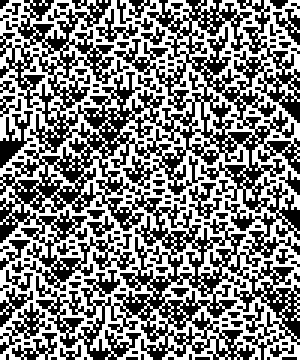

In [83]:
def day18_visualize(s, num_rows=120, repeat=3):  # Visualize.
  state = np.array([False] + [ch == '^' for ch in s.strip()] + [False])
  grid = np.empty((num_rows, len(state[1:-1])), bool)

  for row_index in range(num_rows):
    grid[row_index] = state[1:-1]
    state[1:-1] = state[2:] ^ state[:-2]

  media.show_image(grid.repeat(repeat, axis=0).repeat(repeat, axis=1), border=True, title='day18')


day18_visualize(puzzle.input)

In [84]:
@numba.njit  # Using numba; 1000x speedup over Python "for" loops.
def day18_process(state, num_rows):
  num_safe = 0
  state2 = state.copy()

  for _ in range(num_rows):
    for i in range(1, len(state) - 1):
      num_safe += not state[i]
      state2[i] = state[i - 1] ^ state[i + 1]
    state, state2 = state2, state

  return num_safe


def day18(s, *, num_rows=40):
  state = np.array([False] + [ch == '^' for ch in s.strip()] + [False])
  return day18_process(state, num_rows)


check_eq(day18('..^^.', num_rows=3), 6)
check_eq(day18('.^^.^.^^^^', num_rows=10), 38)
puzzle.verify(1, day18)

day18_part2 = functools.partial(day18, num_rows=400_000)
puzzle.verify(2, day18_part2)

(Part 1: 0.000 s)
(Part 2: 0.010 s)


<a name="day19"></a>
## Day 19: Gift stealing across circle

- Part 1: Elves take turns stealing all the presents from the Elf to their left.  With the number of Elves given in your puzzle input, which Elf gets all the presents?

- Part 2: Elves steal presents from the Elf directly across the circle.  With the number of Elves given in your puzzle input, which Elf now gets all the presents?

In [85]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2016/day/19), `puzzle.input` has a single line of 7 characters:

3017957


The stored answers are: `{1: '1841611', 2: '1423634'}`

In [86]:
def day19a_part1(s):
  n = int(s)
  queue = collections.deque(range(1, n + 1))
  while len(queue) > 1:
    queue.rotate(-1)
    queue.popleft()
  return queue.pop()


check_eq(day19a_part1('5'), 3)
puzzle.verify(1, day19a_part1)

(Part 1: 0.279 s)


In [87]:
def day19a_part1_find_pattern():
  for i in range(2, 18):
    hh.display_html(f'value({i:02}) = {day19a_part1(str(i))}')


day19a_part1_find_pattern()

In [88]:
def day19_part1(s):  # Analytic solution derived from pattern detected above.
  n = int(s)
  # Pattern for function f(n):
  # If 2**(k-1) < n <= 2**k, then f(n) = (n - 2**(k-1)) * 2 + 1
  k = math.ceil(math.log(n) / math.log(2))
  return (n - 2 ** (k - 1)) * 2 + 1


check_eq(day19_part1('5'), 3)
puzzle.verify(1, day19_part1)

(Part 1: 0.000 s)


In [89]:
def day19a_part2(s):  # Impractical quadratic complexity.
  num = int(s)
  queue = collections.deque(range(1, num + 1))
  while len(queue) > 1:
    across = len(queue) // 2
    queue.rotate(-across)
    queue.popleft()
    queue.rotate(across - 1)  # -1 to advance to left
  return queue.pop()


check_eq(day19a_part2('5'), 2)
# puzzle.verify(2, day19_part2)  # Impossibly slow.

In [90]:
def day19a_part2_find_pattern():
  for i in range(2, 30):
    hh.display_html(f'value({i:02}) = {day19a_part2(str(i))}')


day19a_part2_find_pattern()

In [91]:
def day19_part2(s):  # Analytic solution derived from pattern detected above.
  n = int(s)
  # Pattern for function f(n):
  # We can always find k such that 3**(k-1) < n <= 3**k.
  # If 3**(k-1) < n <= 2 * 3**(k-1), then f(n) = n - 3**(k-1).
  # If 2 * 3**(k-1) < n <= 3**k,     then f(n) = n * 2 - 3**k.
  k = math.ceil(math.log(n) / math.log(3))
  return n - 3 ** (k - 1) if n <= 2 * 3 ** (k - 1) else n * 2 - 3**k


check_eq(day19_part2('5'), 2)
puzzle.verify(2, day19_part2)

(Part 2: 0.000 s)


<a name="day20"></a>
## Day 20: Disallowed integer ranges

- Part 1: Given the list of blocked IPs you retrieved from the firewall (your puzzle input), what is the lowest-valued IP that is not blocked?

- Part 2: How many IPs are allowed by the blacklist?

In [92]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2016/day/20), `puzzle.input` has 945 lines:

2803551464-2812875810
3863319608-3871068145
881357481-892360003
1109987968-1119969449
3658860150-3661459953
3315323905-3317364128
4198570301-4213558177
3652285991-3657587289
 ...
3529743404-3545604807
3180438225-3183736951
3233823029-3240497576
3401028250-3405865033


The stored answers are: `{1: '14975795', 2: '101'}`

In [93]:
s1 = """\
5-8
0-2
4-7
"""

In [94]:
def day20_part1(s):  # Part 1: Search over sorted candidates just below disallowed ranges; O(k^2).
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]
  candidates = sorted(start - 1 for start, _ in disallowed if start > 0)
  for x in candidates:
    if not any(start <= x < stop for start, stop in disallowed):
      return x

  raise ValueError('No solution found.')


check_eq(day20_part1(s1), 3)
puzzle.verify(1, day20_part1)

(Part 1: 0.001 s)


In [95]:
def day20a_part2(s, *, stop=2**32):  # Brute-force numpy array; O(stop * k).
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]
  array = np.full(stop, True)
  for start0, stop0 in disallowed:
    array[start0:stop0] = False
  return np.sum(array)


check_eq(day20a_part2(s1, stop=10), 2)
if 0:
  puzzle.verify(2, day20a_part2)  # Slow; ~3.3 s.

In [96]:
def day20b_part2(s, *, stop=2**32):  # Binary subdivision; O(max(k, log(stop)) * k).
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]

  def count_allowed(start: int, stop: int) -> int:
    if any(start >= start0 and stop <= stop0 for start0, stop0 in disallowed):
      return 0
    if all(start >= stop0 or stop <= start0 for start0, stop0 in disallowed):
      return stop - start
    mid = (start + stop) // 2
    assert start < mid < stop
    return count_allowed(start, mid) + count_allowed(mid, stop)

  return count_allowed(0, stop)


check_eq(day20b_part2(s1, stop=10), 2)
puzzle.verify(2, day20b_part2)

(Part 2: 0.231 s)


In [97]:
def day20_part2(s, *, size=2**32):  # Iteratively update list of allowed regions.
  allowed = [(0, size)]
  disallowed = [(l, h + 1) for line in s.splitlines() for l, h in [map(int, line.split('-'))]]

  for start0, stop0 in disallowed:
    allowed2 = []
    for start, stop in allowed:
      if stop0 <= start or start0 >= stop:
        allowed2.append((start, stop))
      elif start0 <= start and stop0 >= stop:
        pass
      elif start0 > start and stop0 < stop:
        allowed2.append((start, start0))
        allowed2.append((stop0, stop))
      elif start0 <= start:
        allowed2.append((max(start, stop0), stop))
      else:
        allowed2.append((start, min(stop, start0)))
    allowed = allowed2

  return sum(stop - start for start, stop in allowed)


check_eq(day20_part2(s1, size=10), 2)
puzzle.verify(2, day20_part2)

(Part 2: 0.007 s)


<a name="day21"></a>
## Day 21: Scrambling of string

- Part 1: Given the list of scrambling operations in your puzzle input, what is the result of scrambling abcdefgh?

- Part 2: What is the un-scrambled version of the scrambled password fbgdceah?

In [98]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2016/day/21), `puzzle.input` has 100 lines:

rotate right 4 steps
swap letter b with letter e
swap position 1 with position 3
reverse positions 0 through 4
rotate left 5 steps
swap position 6 with position 5
move position 3 to position 2
move position 6 to position 5
 ...
rotate based on position of letter f
rotate left 7 steps
rotate based on position of letter e
swap position 6 with position 1


The stored answers are: `{1: 'dbfgaehc', 2: 'aghfcdeb'}`

In [99]:
s1 = """\
swap position 4 with position 0
swap letter d with letter b
reverse positions 0 through 4
rotate left 1 step
move position 1 to position 4
move position 3 to position 0
rotate based on position of letter b
rotate based on position of letter d
"""

In [100]:
def day21(s, *, initial=None, part2=False, debug=False):
  lines = s.splitlines()
  initial = initial or ('fbgdceah' if part2 else 'abcdefgh')
  state = list(initial)
  num = len(state)
  # Index of letter at index after "rotate based on position of letter"; used for inversion.
  rotate_on_letter = [(index + (1 + index + (index >= 4))) % num for index in range(num)]

  def scramble1(state: list[str], line: str, invert: bool) -> list[str]:
    if match := re.fullmatch(r'swap position (\d+) with position (\d+)', line):
      i0, i1 = map(int, match.groups())
      assert 0 <= i0 < num and 0 <= i1 < num and i0 != i1
      state[i0], state[i1] = state[i1], state[i0]
    elif match := re.fullmatch(r'swap letter (\w) with letter (\w)', line):
      ch0, ch1 = match.groups()
      assert ch0 != ch1
      i0, i1 = state.index(ch0), state.index(ch1)
      state[i0], state[i1] = ch1, ch0
    elif match := re.fullmatch(r'rotate (left|right) (\d+) steps?', line):
      direction, delta = match.group(1), int(match.group(2))
      if invert:
        direction = 'left' if direction == 'right' else 'right'
      assert 0 <= delta < num
      delta = -delta % num if direction == 'right' else delta
      state = state[delta:] + state[:delta]  # Rotate left by delta (which can be 0).
    elif match := re.fullmatch(r'rotate based on position of letter (\w)', line):
      (ch,) = match.groups()
      index = state.index(ch)
      if invert:
        (index2,) = [i0 for i0, i1 in enumerate(rotate_on_letter) if i1 == index]
        delta = (1 + index2 + (index2 >= 4)) % num
        check_eq((index2 + delta) % num, index)
      else:
        delta = -(1 + index + (index >= 4)) % num  # Rotate right is negative delta.
      state = state[delta:] + state[:delta]  # Rotate left by delta (which can be 0).
      # index -> (index - delta) % num.
    elif match := re.fullmatch(r'reverse positions (\d+) through (\d+)', line):
      i0, i1 = map(int, match.groups())
      assert i0 <= i1
      state[i0 : i1 + 1] = reversed(state[i0 : i1 + 1])
    elif match := re.fullmatch(r'move position (\d+) to position (\d+)', line):
      i0, i1 = map(int, match.groups())
      assert 0 <= i0 < num and 0 <= i1 < num and i0 != i1
      if invert:
        i0, i1 = i1, i0
      ch = state[i0]
      state = state[:i0] + state[i0 + 1 :]
      state = state[:i1] + [ch] + state[i1:]
    else:
      raise ValueError(line)
    return state

  def scramble(state: list[str], lines: list[str], invert: bool) -> list[str]:
    lines2 = lines[::-1] if invert else lines
    for line in lines2:
      if invert and debug:
        assert scramble1(scramble1(state.copy(), line, True), line, False) == state, line
      state = scramble1(state, line, invert)
    return state

  state = scramble(state, lines, part2)
  return ''.join(state)


check_eq(day21(s1, initial='abcde'), 'decab')
puzzle.verify(1, day21)

day21_part2 = functools.partial(day21, part2=True)
_ = day21_part2(puzzle.input, debug=True)
puzzle.verify(2, day21_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day22"></a>
## Day 22: Grid of storage disks

- Part 1: How many viable pairs (A is not empty; A != B; data of A would fit on B) of nodes are there?

- Part 2: What is the fewest number of steps required to move your goal data to node-x0-y0?

(Note: the puzzle description has bugs; it incorrectly refers to `node-y0-x1` instead of `node-x1-y0`.)

In [101]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2016/day/22), `puzzle.input` has 992 lines:

root@ebhq-gridcenter# df -h
Filesystem              Size  Used  Avail  Use%
/dev/grid/node-x0-y0     88T   67T    21T   76%
/dev/grid/node-x0-y1     85T   73T    12T   85%
/dev/grid/node-x0-y2     94T   73T    21T   77%
/dev/grid/node-x0-y3     91T   72T    19T   79%
/dev/grid/node-x0-y4     93T   71T    22T   76%
/dev/grid/node-x0-y5     87T   65T    22T   74%
 ...
/dev/grid/node-x32-y26   89T   72T    17T   80%
/dev/grid/node-x32-y27  501T  496T     5T   99%
/dev/grid/node-x32-y28   88T   73T    15T   82%
/dev/grid/node-x32-y29   90T   65T    25T   72%


The stored answers are: `{1: '960', 2: '225'}`

In [102]:
def day22(s, *, part2=False, debug=False):
  lines = s.splitlines()[2:]
  shape = tuple(int(e) + 1 for e in hh.re_groups(r'node-x(\d+)-y(\d+)\s', lines[-1]))[::-1]  # y, x
  check_eq(len(lines), math.prod(shape))
  size, used, avail = np.full(shape, -1), np.full(shape, -1), np.full(shape, -1)
  for line in lines:
    pattern = r'^/dev/grid/node-x(\d+)-y(\d+)\s+(\d+)T\s+(\d+)T\s+(\d+)T\s+\d+%$'
    x, y, size1, used1, avail1 = map(int, hh.re_groups(pattern, line))
    size[y, x], used[y, x], avail[y, x] = size1, used1, avail1

  def check_assumptions() -> None:
    assert size.min() >= 0 and used.min() >= 0 and avail.min() >= 0  # Loaded data is complete.
    assert (used == 0).sum() == 1  # There is only one free node.
    assert used[0, -1] < size.min()  # All nodes can hold the (upper-right) data.
    assert used[used > 0].min() > avail[used > 0].max()  # Data can only transfer to the free node.
    assert size[~large].max() < large_value  # Data from large nodes can never move.
    assert np.all(~large[0])  # There are no large nodes on the topmost grid row.

  large_value = used[used > size.min()].min()
  large = used >= large_value
  check_assumptions()

  if debug:
    hh.show(used[0, -1], size.min(), large_value, used[used > 0].min(), avail[used > 0].max())
    with np.printoptions(linewidth=1000):
      print(f'size:\n{size}\nused:\n{used}\navail:\n{avail}')

  if not part2:
    if 0:  # Slow.
      return sum(
          1
          for x0, y0 in np.ndindex(shape)
          for x1, y1 in np.ndindex(shape)
          if (x0 != x1 or y0 != y1) and used[x0, y0] > 0 and used[x0, y0] <= avail[x1, y1]
      )
    return used.size - 1 - large.sum()

  # I initially solved Part 2 using paper and pencil!

  # Compute the length of the shortest path from the free node to the node left of the upper-right.
  ((y0, x0),) = np.argwhere(used == 0)
  queue = collections.deque([(y0, x0, 0)])
  seen = set()
  while True:
    y, x, length = queue.popleft()
    if (y, x) == (0, shape[1] - 2):  # Node to the left of the upper-right node.
      break
    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
      y2, x2 = y + dy, x + dx
      if 0 <= y2 < shape[0] and 0 <= x2 < shape[1] and not large[y2, x2] and (y2, x2) not in seen:
        seen.add((y2, x2))
        queue.append((y2, x2, length + 1))

  # Add the motions to move the data on the upper row.
  length += 1 + (4 + 1) * (shape[1] - 2)

  return length


puzzle.verify(1, day22)

day22_part2 = functools.partial(day22, part2=True)
puzzle.verify(2, day22_part2)

(Part 1: 0.003 s)
(Part 2: 0.003 s)


<a name="day23"></a>
## Day 23: Self-toggling program

- Part 1: Place 7 in register a, run the code.  What is the value left in register a?

- Part 2: Place 12 in register a, run the code.  What is the value left in register a?

In [103]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2016/day/23), `puzzle.input` has 26 lines:

cpy a b
dec b
cpy a d
cpy 0 a
cpy b c
inc a
dec c
jnz c -2
 ...
inc d
jnz d -2
inc c
jnz c -5


The stored answers are: `{1: '12071', 2: '479008631'}`

In [104]:
s1 = """\
cpy 2 a
tgl a
tgl a
tgl a
cpy 1 a
dec a
dec a
"""

In [105]:
def day23(s, *, part2=False, debug=False):
  def compute(initial_a: int) -> int:
    instructions = [line.split() for line in s.splitlines()]
    registers = collections.defaultdict(int)
    registers['a'] = initial_a
    program_counter = 0

    def get_value(src: str) -> int:
      return registers[src] if src.isalpha() else int(src)

    while 0 <= program_counter < len(instructions):
      match instructions[program_counter]:
        case 'cpy', src, dst:
          if dst.isalpha():
            registers[dst] = get_value(src)
        case 'inc', register:
          if register.isalpha():
            registers[register] += 1
        case 'dec', register:
          if register.isalpha():
            registers[register] -= 1
        case 'jnz', predicate, offset:
          if get_value(predicate) != 0:
            program_counter += get_value(offset) - 1
        case 'tgl', register:
          assert register.isalpha()
          pc2 = program_counter + registers[register]
          if debug:
            hh.show('tgl', program_counter, registers, pc2)
          if 0 <= pc2 < len(instructions):
            instruction = instructions[pc2]
            old_instruction = instruction.copy()
            match instruction:
              case 'inc', _:
                instruction[0] = 'dec'
              case _, _:
                instruction[0] = 'inc'
              case 'jnz', _, _:
                instruction[0] = 'cpy'
              case _, _, _:
                instruction[0] = 'jnz'
            if debug:
              hh.show(pc2, old_instruction, instruction)
          if registers['b'] > 1 and not debug:  # Multiplication optimization.
            check_eq(program_counter, 16)
            registers['a'] *= registers['b']
            registers['b'] -= 1
            registers['c'] -= 2
            program_counter -= 1
        case x:
          raise ValueError(x)
      program_counter += 1

    assert set(registers) <= set('abcd')
    return registers['a']

  if debug:
    for initial_a in range(6, 10):
      hh.show(initial_a, compute(initial_a))
    raise hh.StopExecution

  return compute(12 if part2 else 7)


check_eq(day23(s1), 3)
puzzle.verify(1, day23)

day23_part2 = functools.partial(day23, part2=True)
puzzle.verify(2, day23_part2)

(Part 1: 0.004 s)
(Part 2: 0.005 s)


In [106]:
if 0:
  _ = day23(puzzle.input, debug=True)

In [107]:
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 30, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 120, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 360, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 720, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 6, compute(initial_a) = 7751
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 42, 'b': 5, 'd': 0, 'c': 10}), pc2 = 26
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 210, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 840, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 2520, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 5040, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 7, compute(initial_a) = 12071
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 56, 'b': 6, 'd': 0, 'c': 12}), pc2 = 28
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 336, 'b': 5, 'd': 0, 'c': 10}), pc2 = 26
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 1680, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 6720, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 20160, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 40320, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 8, compute(initial_a) = 47351
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 72, 'b': 7, 'd': 0, 'c': 14}), pc2 = 30
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 504, 'b': 6, 'd': 0, 'c': 12}), pc2 = 28
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 3024, 'b': 5, 'd': 0, 'c': 10}), pc2 = 26
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 15120, 'b': 4, 'd': 0, 'c': 8}), pc2 = 24
# pc2 = 24, old_instruction = ['inc', 'c'], instruction = ['dec', 'c']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 60480, 'b': 3, 'd': 0, 'c': 6}), pc2 = 22
# pc2 = 22, old_instruction = ['inc', 'd'], instruction = ['dec', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 181440, 'b': 2, 'd': 0, 'c': 4}), pc2 = 20
# pc2 = 20, old_instruction = ['jnz', '79', 'd'], instruction = ['cpy', '79', 'd']
# tgl, program_counter = 16, registers = defaultdict(<class 'int'>, {'a': 362880, 'b': 1, 'd': 0, 'c': 2}), pc2 = 18
# pc2 = 18, old_instruction = ['jnz', '1', 'c'], instruction = ['cpy', '1', 'c']
# initial_a = 9, compute(initial_a) = 369911
# <StopExecution>

<a name="day24"></a>
## Day 24: Path visiting all maze nodes

- Part 1: Given your actual map, and starting from location 0, what is the fewest number of steps required to visit every non-0 number marked on the map at least once?

- Part 2: What is the fewest number of steps required to start at 0, visit every non-0 number marked on the map at least once, and then return to 0?

In [108]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2016/day/24), `puzzle.input` has 41 lines:

################################################################################ ... ###################################
#.#.......#.#.#.....#.#.......#.................#.......#.#.....#.....#...#...#. ... ........#.....#.#.............#...#
#.#####.#.#.#.#.#.#.#.#.#.###.#.#.###.#.#.###.###.#.#.#.#.#.#####.#.#.###.#.#.## ... #.#.#.#.#.#.#.#.#.###.#####.#.###.#
#.....#.............#...#....6#.....#.....#.#...#.....#...#.........#.......#... ... #.........#.....#...#.#.#.#.....#.#
#####.#.###.###.#.#.#.#####.#.#####.#.#####.#.#######.#.#.#.#.#.#####.#####.#.## ... #.#.#.#.#.#.###########.#.#.#####.#
#.....#.......#.#.....#.......#.#...#.#.#.#...........#.....#.#.#...#.#...#.#.#. ... #.....#...#.......#.#...#.#.....#.#
###.#.#.#.#####.#####.#.#.#.#.#.#.#.#.#.#.#########.#.#########.#.#.###.###.###. ... #.#.#.###.###.#.#.#.#.#.###.#.#####
#...#...#.#.....#.............#...#...#...#.#.......#.#.#...#...#.#.#...#.....#. ... #...#.....#.#.......#.#.#...#...#.#
 ...
#.....#.....#.#............

The stored answers are: `{1: '500', 2: '748'}`

In [109]:
s1 = """\
###########
#0.1.....2#
#.#######.#
#4.......3#
###########
"""

In [110]:
def day24a(s, *, part2=False, visualize=False):  # Find shortest path over all node permutations.
  grid = np.array([list(line) for line in s.splitlines()])
  num_nodes = np.max(grid[np.char.isdigit(grid)].astype(int)) + 1
  node_yx = [(y, x) for node in range(num_nodes) for y, x in [np.argwhere(grid == str(node))[0]]]

  @functools.cache
  def get_paths(node0: int) -> dict[int, list[tuple[int, int]]]:
    # Return shortest paths from node0 to all other nodes.
    yx0 = node_yx[node0]
    queue = collections.deque([yx0])
    prev: dict[tuple[int, int], tuple[int, int]] = {}
    paths = {}
    while queue:
      yx = queue.popleft()
      if grid[yx].isdigit() and yx != yx0:
        path = [yx]
        yxt = yx
        while (yxt := prev[yxt]) != yx0:
          path.append(yxt)
        paths[int(grid[yx])] = path[::-1]
      for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        yx2 = yx[0] + dy, yx[1] + dx
        if grid[yx2] != '#' and yx2 not in prev:
          prev[yx2] = yx
          queue.append(yx2)
    return paths

  def node_distance(node0: int, node1: int) -> int:
    return len(get_paths(node0)[node1])

  def node_sequence_distance(sequence: Iterable[int]) -> int:
    return sum(node_distance(node0, node1) for node0, node1 in itertools.pairwise(sequence))

  def node_sequence(permutation: Iterable[int]) -> list[int]:
    return [0] + list(permutation) + [0] if part2 else [0] + list(permutation)

  def permutation_distance(permutation: Iterable[int]) -> int:
    return node_sequence_distance(node_sequence(permutation))

  def permutation_path(permutation: Iterable[int]) -> list[tuple[int, int]]:
    sequence = node_sequence(permutation)
    path = [node_yx[sequence[0]]]
    for node0, node1 in itertools.pairwise(sequence):
      path.extend(get_paths(node0)[node1])
    return path

  permutations = itertools.permutations(range(1, num_nodes))
  permutation = min(permutations, key=permutation_distance)

  if visualize:
    path = permutation_path(permutation)
    images = []
    image = hh.to_image(grid == '#', 245, 10)
    image[np.char.isdigit(grid)] = 255, 0, 0
    for node in path:
      if not grid[node].isdigit():
        image[node][[0, 1]] //= 2
      images.append(image.repeat(4, axis=0).repeat(4, axis=1))
    images = [images[0]] * 40 + images + [images[-1]] * 100
    media.show_video(images, codec='gif', fps=50, title='day24')

  return permutation_distance(permutation)


check_eq(day24a(s1), 14)
puzzle.verify(1, day24a)

day24a_part2 = functools.partial(day24a, part2=True)
puzzle.verify(2, day24a_part2)

(Part 1: 0.060 s)
(Part 2: 0.058 s)


day24

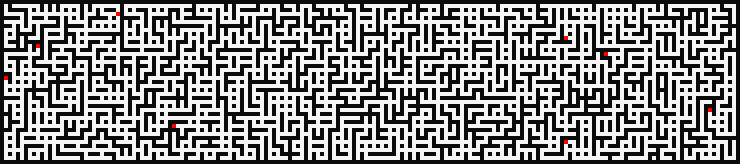

In [111]:
_ = day24a(puzzle.input, visualize=True, part2=True)

In [112]:
def day24(s, *, part2=False):  # Use Dijkstra where the state includes the set of visited nodes.
  grid = np.array([list(line) for line in s.splitlines()])
  num_nodes = np.max(grid[np.char.isdigit(grid)].astype(int)) + 1
  node_yx = [(y, x) for node in range(num_nodes) for y, x in [np.argwhere(grid == str(node))[0]]]

  @functools.cache
  def get_distances(node0: int) -> dict[int, int]:
    yx = node_yx[node0]
    queue = [yx]
    seen = {yx}
    distances = {}
    distance = 0
    while queue:
      queue2 = []
      for yx in queue:
        if grid[yx].isdigit():
          distances[int(grid[yx])] = distance
        for dy, dx in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
          yx2 = yx[0] + dy, yx[1] + dx
          if grid[yx2] != '#' and yx2 not in seen:
            seen.add(yx2)
            queue2.append(yx2)
      queue = queue2
      distance += 1
    return distances

  def get_distance(node0: int, node1: int) -> int:
    return get_distances(node0)[node1]

  all_nodes = frozenset(range(1, num_nodes))
  state = 0, frozenset[int]()  # node, visited
  distances = {}
  distances[state] = 0
  priority_queue = [(0, state)]
  while priority_queue:
    distance, state = heapq.heappop(priority_queue)
    node, visited = state
    if len(visited) == (num_nodes - (0 if part2 else 1)):
      return distance
    candidates = all_nodes - visited
    if part2 and not candidates:
      candidates = frozenset({0})  # For Part 2, complete the cycle back to the start node.
    for node2 in candidates:
      visited2 = visited | {node2}
      state2 = node2, visited2
      distance2 = distance + get_distance(node, node2)
      if distance2 < distances.get(state2, 10**9):
        distances[state2] = distance2
        heapq.heappush(priority_queue, (distance2, state2))

  raise ValueError('No solution found.')


check_eq(day24(s1), 14)
puzzle.verify(1, day24)

day24_part2 = functools.partial(day24, part2=True)
puzzle.verify(2, day24_part2)

(Part 1: 0.051 s)
(Part 2: 0.052 s)


<a name="day25"></a>
## Day 25: Program to generate clock

- Part 1: What is the lowest positive integer that can be used to initialize register a and cause the code to output a clock signal of 0, 1, 0, 1... repeating forever?

- Part 2: No Part 2 on day 25.

In [113]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2016/day/25), `puzzle.input` has 30 lines:

cpy a d
cpy 7 c
cpy 362 b
inc d
dec b
jnz b -2
dec c
jnz c -5
 ...
jnz 0 0
out b
jnz a -19
jnz 1 -21


The stored answers are: `{1: '196', 2: ''}`

In [114]:
def day25a(s, debug=False):
  instructions = [line.split() for line in s.splitlines()]

  def desired_output() -> Iterator[int]:
    return itertools.cycle([0, 1])

  def compute_output(initial_a: int) -> Iterator[int]:
    assert initial_a > 0
    registers = dict(a=initial_a, b=0, c=0, d=0)
    program_counter = 0

    def get_value(src: str) -> int:
      return registers[src] if src.isalpha() else int(src)

    while True:
      match instructions[program_counter]:
        case 'cpy', src, dst:
          registers[dst] = get_value(src)
        case 'inc', register:
          registers[register] += 1
        case 'dec', register:
          registers[register] -= 1
        case 'jnz', predicate, offset:
          if get_value(predicate) != 0:
            program_counter += get_value(offset) - 1
        case 'out', src:
          yield get_value(src)
        case x:
          raise ValueError(x)
      program_counter += 1

  def equal_prefix(values1: Iterable[int], values2: Iterable[int], length: int) -> bool:
    prefix1, prefix2 = itertools.islice(values1, length), itertools.islice(values2, length)
    return more_itertools.iequals(prefix1, prefix2)

  if debug:
    for initial_a in range(180, 200):
      output = itertools.islice(compute_output(initial_a), 30)
      s_output = ''.join(str(value) for value in output)
      hh.display_html(f'{initial_a:3} {s_output}')
    return

  for initial_a in range(1, 2000):
    if equal_prefix(compute_output(initial_a), desired_output(), 30):
      return initial_a


puzzle.verify(1, day25a)
puzzle.verify(2, lambda s: '')

(Part 1: 1.041 s)
(Part 2: 0.000 s)


In [115]:
_ = day25a(puzzle.input, debug=True)

In [116]:
# Using numba.
Day25Op = enum.IntEnum('Day25Op', ['CPY_REG', 'CPY_VAL', 'INC', 'DEC', 'JNZ_REG', 'JNZ_VAL', 'OUT'])


@numba.njit
def day25_compute(instructions: np.ndarray, initial_a: int) -> Iterator[int]:
  registers = [initial_a, 0, 0, 0]
  program_counter = 0
  while True:
    assert 0 <= program_counter < len(instructions)
    instruction = instructions[program_counter]
    op, args = instruction[0], instruction[1:]
    # Unfortunately, "numba" does not yet have match/case control structure.
    if op == Day25Op.CPY_REG:
      registers[args[1]] = registers[args[0]]
    elif op == Day25Op.CPY_VAL:
      registers[args[1]] = args[0]
    elif op == Day25Op.INC:
      registers[args[0]] += 1
    elif op == Day25Op.DEC:
      registers[args[0]] -= 1
    elif op == Day25Op.JNZ_REG:
      if registers[args[0]] != 0:
        program_counter += args[1] - 1
    elif op == Day25Op.JNZ_VAL:
      if args[0] != 0:
        program_counter += args[1] - 1
    elif op == Day25Op.OUT:
      yield registers[args[0]]
    else:
      raise ValueError
    program_counter += 1


def day25(s):
  def encode(register: str) -> int:
    return 'abcd'.index(register)

  instructions: list[list[int]] = []
  for line in s.splitlines():
    match line.split():
      case 'cpy', src, dst:
        if src.isalpha():
          instructions.append([Day25Op.CPY_REG, encode(src), encode(dst)])
        else:
          instructions.append([Day25Op.CPY_VAL, int(src), encode(dst)])
      case 'inc', register:
        instructions.append([Day25Op.INC, encode(register), 0])
      case 'dec', register:
        instructions.append([Day25Op.DEC, encode(register), 0])
      case 'jnz', predicate, offset:
        assert not offset.isalpha()
        if predicate.isalpha():
          instructions.append([Day25Op.JNZ_REG, encode(predicate), int(offset)])
        else:
          instructions.append([Day25Op.JNZ_VAL, int(predicate), int(offset)])
      case 'out', register:
        instructions.append([Day25Op.OUT, encode(register), 0])
      case x:
        raise ValueError(x)

  def compute_output(initial_a: int) -> Iterator[int]:
    yield from day25_compute(np.array(instructions), initial_a)

  def desired_output() -> Iterator[int]:
    return itertools.cycle([0, 1])

  def equal_prefix(values1: Iterable[int], values2: Iterable[int], length: int) -> bool:
    prefix1, prefix2 = itertools.islice(values1, length), itertools.islice(values2, length)
    return more_itertools.iequals(prefix1, prefix2)

  for initial_a in range(1, 2000):
    if equal_prefix(compute_output(initial_a), desired_output(), 30):
      return initial_a


_ = day25(puzzle.input)  # For numba compilation.
puzzle.verify(1, day25)

(Part 1: 0.023 s)


In [117]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)

(Part 2: 0.000 s)


In [118]:
# You activate all fifty stars and transmit the signal. The star atop the antenna begins to glow.
# Suddenly, you see the sleigh fly past you!Looks like Santa was already waiting for your signal.
# Congratulations!  You've finished every puzzle in Advent of Code 2016!
# I hope you had as much fun solving them as I had making them for you.
# I'd love to hear about your adventure; you can get in touch with me via contact info on my website or through Twitter.
# If you'd like to see more things like this in the future, please consider supporting Advent of Code and sharing it with others.
# To hear about future projects, you can follow me on Twitter.
# I've highlighted the easter eggs in each puzzle, just in case you missed any.  Hover your mouse over them, and the easter egg will appear.

<a name="timings"></a>
## Timings

In [119]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.000
day_2    part_1: 0.000   part_2: 0.000
day_3    part_1: 0.002   part_2: 0.003
day_4    part_1: 0.008   part_2: 0.005
day_5    part_1: 0.458   part_2: 1.076
day_6    part_1: 0.000   part_2: 0.000
day_7    part_1: 0.018   part_2: 0.021
day_8    part_1: 0.001   part_2: 0.001
day_9    part_1: 0.000   part_2: 0.001
day_10   part_1: 0.000   part_2: 0.001
day_11   part_1: 0.007   part_2: 0.038
day_12   part_1: 0.000   part_2: 0.000
day_13   part_1: 0.000   part_2: 0.000
day_14   part_1: 0.192   part_2: 1.139
day_15   part_1: 0.000   part_2: 0.000
day_16   part_1: 0.000   part_2: 0.041
day_17   part_1: 0.000   part_2: 0.043
day_18   part_1: 0.000   part_2: 0.010
day_19   part_1: 0.000   part_2: 0.000
day_20   part_1: 0.001   part_2: 0.007
day_21   part_1: 0.000   part_2: 0.000
day_22   part_1: 0.003   part_2: 0.003
day_23   part_1: 0.004   part_2: 0.005
day_24   part_1: 0.051   part_2: 0.052
day_25   part_1: 0.023   part_2: 0.000
Total time:  3.218 s


In [120]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [121]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^_|(day|Day|s)\d+|(puzzle$)', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [122]:
if 0:  # Lint.
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  hh.run(
      'echo flake8; flake8 --indent-size=2 --exclude .ipynb_checkpoints'
      ' --extend-ignore E129,E203,E302,E305,E501,E741'
  )

In [123]:
hh.show_notebook_cell_top_times()

# Total time: 26.24 s
# In[ 15] def day1_visualize(s, *, repeat=2):\n  y, x = 0, 0  #        2.816 s
# In[111] _ = day24a(puzzle.input, visualize=True, part2=True)         2.604 s
# In[ 55] # Same but faster using numba -- we must omit the            2.446 s
# In[ 30] # Faster multiprocessing solution; also, small speedup       2.075 s
# In[ 76] def day16a(s, *, length=272):\n  s = s.strip()\n             2.062 s
# In[ 82] def day18b(s, *, num_rows=40):  # Using numpy.\n  state =    1.505 s
# In[ 70] # Faster multiprocessing solution.\ndef day14_part2(s):\n    1.210 s
# In[114] def day25a(s, debug=False):\n  instructions = [line.split()  1.202 s
# In[ 73] def day15a(s, *, part2=False):  # Using brute-force search   0.832 s
# In[ 77] @numba.njit\ndef day16_compute(state: np.ndarray, length:    0.729 s
# In[ 66] _ = day13(puzzle.input, visualize=True, part2=False)\n_ =    0.615 s
# In[ 54] def day11c(s, *, part2=False):  # BFS; list of floors;       0.439 s
# In[ 69] def day14a(s, *, par

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->